In [42]:

# Custom functions
from my_functions import *

from matplotlib import pyplot
import pickle

# ML packages
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer, MultiLabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, cross_validate, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score,precision_recall_curve, auc, roc_auc_score, cohen_kappa_score

#from scipy.sparse import hstack
from xgboost import XGBClassifier

# Used for SMOTE:
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline


#### Import data

In [43]:
# import Pickled data
infile = open('bk_data_merged','rb')
df_merge = pickle.load(infile)
infile.close()
print(len(df_merge))

251


## 1) Sentiment Analysis
#### Labelling the reviews 
We will use the original (un-untransformed) reviews attribute for the sentiment analysis

In [44]:
# Determine Sentiment of Reviews; see (Hutto, n.d.)
df_merge['sentiment'] = df_merge['review'].apply(lambda x: sid_analyser(x, True))
df_merge['sentiment_all'] = df_merge['review'].apply(lambda x: sid_analyser(x, False))

# Split overall scores into seperate columns for plotting
df_merge['sentiment_pos'] = df_merge['sentiment'].apply(lambda x: x['pos'])
df_merge['sentiment_neg'] = df_merge['sentiment'].apply(lambda x: x['neg'])
df_merge['sentiment_neu'] = df_merge['sentiment'].apply(lambda x: x['neu'])
df_merge['sentiment_comp'] = df_merge['sentiment'].apply(lambda x: x['compound'])

# Apply overall sentiment classification label
df_merge['sentiment_overall'] = df_merge['sentiment'].apply(lambda x: sentiment_overall(x['compound']))

df_merge.head(2)

,title,year,genre,movie_description,critical_consensus,review,sentiment,sentiment_all,sentiment_pos,sentiment_neg,sentiment_neu,sentiment_comp,sentiment_overall
0,The Hunger Games: Catching Fire,2013,"[Adventure, Sci-Fi, Action]",After arriving safely home from their unpreced...,"Smart, smoothly directed, and enriched with a ...","[Catching Fire delivers on the grim, roiling p...","{'neg': 0.105, 'neu': 0.65, 'pos': 0.246, 'com...","[{'neg': 0.339, 'neu': 0.389, 'pos': 0.272, 'c...",0.246,0.105,0.650,0.9986,positive
1,The Hunger Games: Mockingjay – Part 1,2014,"[Action, Adventure, Sci-Fi]",Following her rescue from the devastating Quar...,The Hunger Games: Mockingjay - Part 1 sets up ...,"[""Mockingjay - Part 1,"" however well done, can...","{'neg': 0.039, 'neu': 0.771, 'pos': 0.19, 'com...","[{'neg': 0.0, 'neu': 0.764, 'pos': 0.236, 'com...",0.190,0.039,0.771,0.9974,positive


In [45]:
# note the data are imbalanced
df_merge['sentiment_overall'].value_counts()

positive    215
negative     35
neutral       1
Name: sentiment_overall, dtype: int64

Text(0.5, 1.0, 'Compound Sentiment')

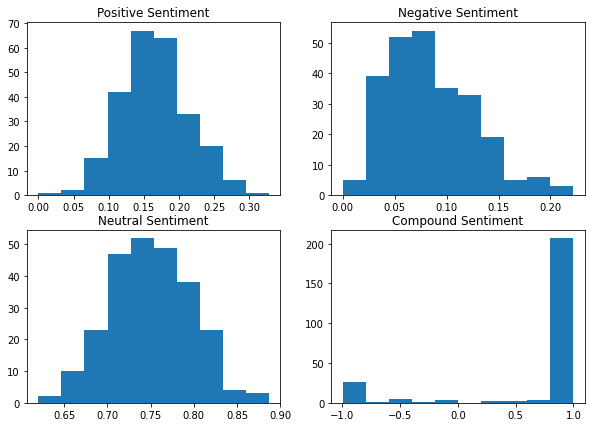

In [46]:
fig, axs = plt.subplots(2, 2, figsize = (10,7))

# Plot the distribution of sentiment
axs[0,0].hist(df_merge['sentiment_pos'])
axs[0,0].set_title("Positive Sentiment")
axs[0,1].hist(df_merge['sentiment_neg'])
axs[0,1].set_title("Negative Sentiment")
axs[1,0].hist(df_merge['sentiment_neu'])
axs[1,0].set_title("Neutral Sentiment")
axs[1,1].hist(df_merge['sentiment_comp'])
axs[1,1].set_title("Compound Sentiment")

**What is the neutral review?**

It looks like the reviews are balanced between positive and negative. As this is the only film that VADER has classified as neutral, we will remove it from the dataset.

In [47]:
# What is the neutral review?
print('Film: ', df_merge[df_merge['sentiment_overall'] == 'neutral']['title'].values)

Film:  ['Thunderball']


In [48]:
# How are the reviews scored individually?
df_merge.head()

sent = []
for i in list(df_merge[df_merge['sentiment_overall'] == 'neutral']['sentiment_all'])[0]:
    sent.append([i['compound'], sentiment_overall(np.mean(i['compound']))])
    
pd.DataFrame(sent)[1].value_counts()

positive    5
negative    3
Name: 1, dtype: int64

In [49]:
# Classify as positive
df_merge.loc[df_merge.title == 'Thunderball', 'sentiment_overall'] = 'positive'

In [50]:
# note the data are imbalanced
df_merge['sentiment_overall'].value_counts()

positive    216
negative     35
Name: sentiment_overall, dtype: int64

## 2) Construct final data model
### Data Cleanup

In [51]:
df_merge.head(2)

,title,year,genre,movie_description,critical_consensus,review,sentiment,sentiment_all,sentiment_pos,sentiment_neg,sentiment_neu,sentiment_comp,sentiment_overall
0,The Hunger Games: Catching Fire,2013,"[Adventure, Sci-Fi, Action]",After arriving safely home from their unpreced...,"Smart, smoothly directed, and enriched with a ...","[Catching Fire delivers on the grim, roiling p...","{'neg': 0.105, 'neu': 0.65, 'pos': 0.246, 'com...","[{'neg': 0.339, 'neu': 0.389, 'pos': 0.272, 'c...",0.246,0.105,0.650,0.9986,positive
1,The Hunger Games: Mockingjay – Part 1,2014,"[Action, Adventure, Sci-Fi]",Following her rescue from the devastating Quar...,The Hunger Games: Mockingjay - Part 1 sets up ...,"[""Mockingjay - Part 1,"" however well done, can...","{'neg': 0.039, 'neu': 0.771, 'pos': 0.19, 'com...","[{'neg': 0.0, 'neu': 0.764, 'pos': 0.236, 'com...",0.190,0.039,0.771,0.9974,positive


In [52]:
# Clean text
# 1) Remove non-letters
# 2) Remove stop words for descriptions and reviews
# 3) Lemmatize text for descriptions and reviews
df_merge['movie_description'] = df_merge['movie_description'].apply(lambda x: clean_text(x, True)) 
df_merge['critical_consensus'] = df_merge['critical_consensus'].apply(lambda x: clean_text(x, True))
df_merge['review_list'] = df_merge['review'].apply(lambda x: clean_text_list(x, True)) 
df_merge['reviews'] = df_merge['review_list'].apply(lambda x: ', '.join(x))

# Change from list to string
df_merge['genre'] = df_merge['genre'].apply(lambda x: ', '.join(x).lower())

df_merge.head(3)

,title,year,genre,movie_description,critical_consensus,review,sentiment,sentiment_all,sentiment_pos,sentiment_neg,sentiment_neu,sentiment_comp,sentiment_overall,review_list,reviews
0,The Hunger Games: Catching Fire,2013,"adventure, sci-fi, action",arriving safely home unprecedented victory th ...,smart smoothly directed enriched deeper explor...,"[Catching Fire delivers on the grim, roiling p...","{'neg': 0.105, 'neu': 0.65, 'pos': 0.246, 'com...","[{'neg': 0.339, 'neu': 0.389, 'pos': 0.272, 'c...",0.246,0.105,0.650,0.9986,positive,[catching fire delivers grim roiling promises ...,catching fire delivers grim roiling promises o...
1,The Hunger Games: Mockingjay – Part 1,2014,"action, adventure, sci-fi",following rescue devastating quarter quell kat...,hunger games mockingjay part sets franchise fi...,"[""Mockingjay - Part 1,"" however well done, can...","{'neg': 0.039, 'neu': 0.771, 'pos': 0.19, 'com...","[{'neg': 0.0, 'neu': 0.764, 'pos': 0.236, 'com...",0.190,0.039,0.771,0.9974,positive,[mockingjay part however well done cant compet...,mockingjay part however well done cant compete...
3,Forrest Gump,1994,"comedy, drama & romance",slow witted forrest gump tom hanks never thoug...,forrest gump may overly sentimental film somew...,"[A dark and driven work, haunted by violence, ...","{'neg': 0.087, 'neu': 0.723, 'pos': 0.19, 'com...","[{'neg': 0.597, 'neu': 0.403, 'pos': 0.0, 'com...",0.190,0.087,0.723,0.9968,positive,[dark driven work haunted violence cruelty sen...,dark driven work haunted violence cruelty sens...


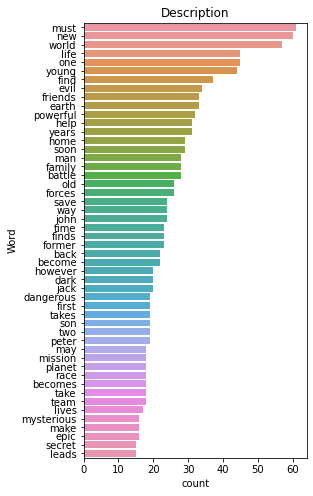

In [53]:
freq_words_chart(df_merge['movie_description'], 50, 'Description', 4)

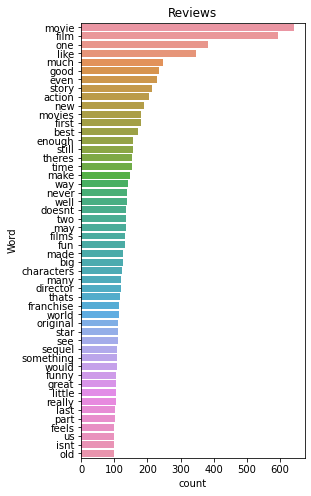

In [54]:
freq_words_chart(df_merge['reviews'], 50, 'Reviews', 4)

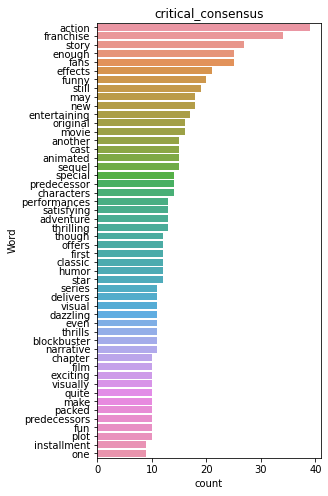

In [55]:
freq_words_chart(df_merge['critical_consensus'], 50, 'critical_consensus', 4)

Text(0.5, 1.0, 'Description word count distribution')

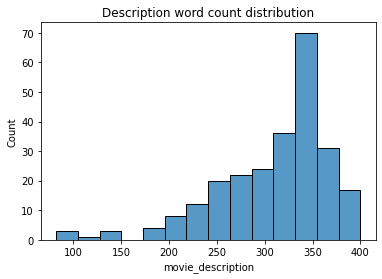

In [56]:
des_len = df_merge['movie_description'].apply(lambda x: len(x))
sns.histplot(des_len)
plt.title('Description word count distribution')

Text(0.5, 1.0, 'Review word count distribution')

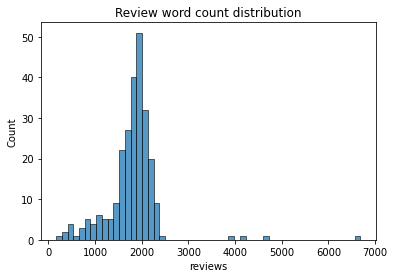

In [57]:
rev_len = df_merge['reviews'].apply(lambda x: len(x))
sns.histplot(rev_len)
plt.title('Review word count distribution')

Text(0.5, 1.0, 'Review word count critical_consensus')

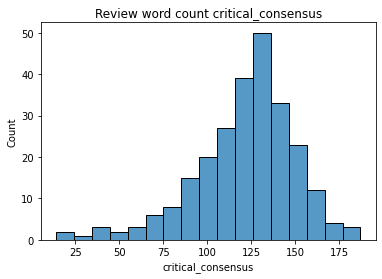

In [58]:
rev_len = df_merge['critical_consensus'].apply(lambda x: len(x))
sns.histplot(rev_len)
plt.title('Review word count critical_consensus')

#### Final Dataframe
Remove columns:
* **review:** original review data
* **worldwide_gross**: not important for this model
* **review_list:** list of cleaned review data
* **sentiment_overall, sentiment_all, sentiment_pos, sentiment_neg, sentiment_neu, sentiment_comp:** we only need sentiment 

In [20]:
df_model = df_merge.copy()

# Binary label for overall sentiment
df_model['sentiment']=df_model['sentiment_overall'].apply(lambda x: 1 if x=='positive' else 0)

# Merge title and year columns
df_model['title'] = df_model.apply(lambda x: x.title + ' (' + str(x.year) + ')', axis = 1)

# Merge X variables
df_model['text'] = (df_model["sentiment"].astype(str)
                    .str.cat(df_model["movie_description"], sep =" ")
                    .str.cat(df_model["critical_consensus"], sep =" ")
                    .str.cat(df_model["reviews"], sep =" ")
                    ).str.strip()

# Final DataFrame
#cols = ['title', 'genre', 'sentiment', 'text']
#df_model = df_model.loc[:, cols]

df_model.head(3)

,title,year,genre,movie_description,critical_consensus,review,sentiment,sentiment_all,sentiment_pos,sentiment_neg,sentiment_neu,sentiment_comp,sentiment_overall,review_list,reviews,text
0,The Hunger Games: Catching Fire (2013),2013,"adventure, sci-fi, action",arriving safely home unprecedented victory th ...,smart smoothly directed enriched deeper explor...,"[Catching Fire delivers on the grim, roiling p...",1,"[{'neg': 0.339, 'neu': 0.389, 'pos': 0.272, 'c...",0.246,0.105,0.650,0.9986,positive,[catching fire delivers grim roiling promises ...,catching fire delivers grim roiling promises o...,1 arriving safely home unprecedented victory t...
1,The Hunger Games: Mockingjay – Part 1 (2014),2014,"action, adventure, sci-fi",following rescue devastating quarter quell kat...,hunger games mockingjay part sets franchise fi...,"[""Mockingjay - Part 1,"" however well done, can...",1,"[{'neg': 0.0, 'neu': 0.764, 'pos': 0.236, 'com...",0.190,0.039,0.771,0.9974,positive,[mockingjay part however well done cant compet...,mockingjay part however well done cant compete...,1 following rescue devastating quarter quell k...
3,Forrest Gump (1994),1994,"comedy, drama & romance",slow witted forrest gump tom hanks never thoug...,forrest gump may overly sentimental film somew...,"[A dark and driven work, haunted by violence, ...",1,"[{'neg': 0.597, 'neu': 0.403, 'pos': 0.0, 'com...",0.190,0.087,0.723,0.9968,positive,[dark driven work haunted violence cruelty sen...,dark driven work haunted violence cruelty sens...,1 slow witted forrest gump tom hanks never tho...


In [21]:
print('Number of films to model: ',len(df_model))

Number of films to model:  251


### Data Wrangling for Model

In [ ]:
# Multilabel Binarizer - applied on y (target) variable
from sklearn.preprocessing import OneHotEncoder
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(df_model['genre'])

# transform target variable
y = multilabel_binarizer.transform(df_model['genre'])

# Transform text to non-numeric form.
# TFIDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features = 1500)

# Split into training and test data sets
X = df_model['text']
X_train, X_test, y_train, y_test = train_test_split(X
                                                    , y
                                                    , test_size = 0.2
                                                    , random_state = 0)

# Create TF-IDF features
X_train = tfidf_vectorizer.fit_transform(X_train)
X_test = tfidf_vectorizer.transform(X_test.values.astype('U'))

# Normalise X data sets
norm = Normalizer()
X_train = norm.fit_transform(X_train)
X_test  = norm.transform(X_test)

#### Treating the Imbalanced data
SMOTE (Synthetic Minority Oversampling Technique) based sampling

### XGBoost

In [ ]:
# Create the random grid
xg_params = {
    "estimator__max_depth": [1, 3, 5, 7, 9],
    "estimator__learning_rate": [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
    "estimator__n_estimators":  [100, 200, 400, 600, 800, 1000],
    "estimator__colsample_bytree": [0.3, 0.5, 0.7],
    "estimator__gamma": [0, 1, 5],
    "estimator__subsample": [0.5 ,0.7 ,1]
}


xg_params

In [ ]:
%%time
xgc = OneVsRestClassifier(XGBClassifier(random_state = 1, verbosity  = 0, use_label_encoder=False, n_jobs = -1))

# search across 50 different combinations, and use all available cores
# Fit the random search model
clf_xgc_random = RandomizedSearchCV(estimator = xgc
                               , param_distributions = xg_params
                               , n_iter = 5
                               , cv = 5
                               , verbose=0
                               , random_state=1
                               , n_jobs = -1
                               , scoring = 'f1_micro'
                               , return_train_score = True)

clf_xgc_random.fit(X_train, y_train)

In [ ]:
# Best hyperparameter values
best_params = clf_xgc_random.best_params_
clf_xgc_random.best_params_

In [ ]:
%%time
# Fit final model with best parameter estimates
xg_final = OneVsRestClassifier(XGBClassifier( max_depth = best_params['estimator__max_depth']
                       , learning_rate = best_params['estimator__learning_rate']
                       , n_estimators = best_params['estimator__n_estimators']
                       , gamma = best_params['estimator__gamma']
                       , subsample = best_params['estimator__subsample']
                       , n_jobs = -1
                       , random_state = 1 
                       , use_label_encoder=False
                       , verbosity  = 0))

xg_final.fit(X_train, y_train )

In [ ]:
%%time

#warnings.filterwarnings(action='once')
# Cross validated metrics
def cv_score (score, cv):
   # with warnings.catch_warnings():
       # warnings.simplefilter("ignore")
        return cross_val_score(xg_final
                            , X_train
                            , y_train
                            , cv = cv
                            , scoring = score
                            , verbose = 0
                            , n_jobs = -1)

scores_lst = []
for i in ["accuracy","f1_micro", "recall_micro", "precision_micro", "roc_auc"]:
    scores_lst.append(cv_score(i, 5))
    

In [ ]:
# Cross validated results
cv_scores_xg = pd.DataFrame(scores_lst).transpose()
cv_scores_xg.columns = ["accuracy","f1_score", "recall_score", "precision_score", "roc_auc"]
cv_scores_xg = pd.DataFrame(cv_scores_xg.mean()).transpose()
cv_scores_xg

In [ ]:
# Performance on training data
y_pred_xg = xg_final.predict(X_train)

train_scores_xg = pd.DataFrame.from_dict({'accuracy' : accuracy_score(y_train, y_pred_xg)
                                 , 'f1_score': f1_score(y_train, y_pred_xg, average="micro")
                                 , 'recall_score': recall_score(y_train, y_pred_xg, average="micro")
                                 , 'precision_score': precision_score(y_train, y_pred_xg, average="micro")
                                 , 'roc_auc': roc_auc_score(y_train, y_pred_xg, average="micro")
                                }, orient = 'index').transpose()

In [ ]:
# Performance on Test data
y_pred_xg = xg_final.predict(X_test)

test_scores_xg = pd.DataFrame.from_dict({'accuracy' : accuracy_score(y_test, y_pred_xg)
                                 , 'f1_score': f1_score(y_test, y_pred_xg, average="micro")
                                 , 'recall_score': recall_score(y_test, y_pred_xg, average="micro")
                                 , 'precision_score': precision_score(y_test, y_pred_xg, average="micro")
                                 , 'roc_auc': roc_auc_score(y_test, y_pred_xg, average="micro")
                                }, orient = 'index').transpose()

In [ ]:
# Dataframe of metric scores
scores_xg = pd.concat([train_scores_xg, cv_scores_xg, test_scores_xg])
scores_xg['Scores'] = ['Training', 'CV', 'Test']
scores_xg.set_index(['Scores'])

In [60]:
df_model = df_merge.copy()

# Binary label for overall sentiment
df_model['sentiment']=df_model['sentiment_overall'].apply(lambda x: 1 if x=='positive' else 0)

# Merge title and year columns
df_model['title'] = df_model.apply(lambda x: x.title + ' (' + str(x.year) + ')', axis = 1)

# Merge X variables
df_model['text'] = (df_model["movie_description"].astype(str)
                    .str.cat(df_model["critical_consensus"], sep =" ")
                    .str.cat(df_model["reviews"], sep =" ")
                    ).str.strip()

# Final DataFrame
cols = ['title', 'genre', 'sentiment', 'text']
df_model = df_model.loc[:, cols]

df_model.head(3)

,title,genre,sentiment,text
0,The Hunger Games: Catching Fire (2013),"adventure, sci-fi, action",1,arriving safely home unprecedented victory th ...
1,The Hunger Games: Mockingjay – Part 1 (2014),"action, adventure, sci-fi",1,following rescue devastating quarter quell kat...
3,Forrest Gump (1994),"comedy, drama & romance",1,slow witted forrest gump tom hanks never thoug...


In [22]:
# importing all necessary modules
from nltk.tokenize import sent_tokenize, word_tokenize
import gensim
from gensim.models import Word2Vec
from sklearn.decomposition import PCA

c:\users\james\appdata\local\programs\python\python39\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [83]:
# init word2vec class (hyperparameters)
model = Word2Vec(size = 200,    # number of dimensions of the embedding, e.g. the length of the dense vector to represent each token (word)
                 window = 15,   # maximum number of words between a target word and words around the target word
                 min_count = 2, # words with an occurrence less than this count will be ignored
                 workers = 20,  # number of threads to use while training
                 sg = 1,        # we are using Skip Gram algorithm; if you set sg = 0 then the algorithm will be CBOW
                 negative = 5,  # negative sampling will be used - downsample words
                 sample = 1e-5) # threshold for configuring which higher-frequency words are randomly downsampled

In [84]:
df_model['text_lst'] = df_model['text'].apply(lambda x: list(set(x.split(' '))))

In [85]:
sent = list(df_model['text_lst'])

In [75]:
from gensim.models import KeyedVectors

# step three: load the pretrained model we just downloaded and unzipped
# model = KeyedVectors.load_word2vec_format('pretrained-model.bin', binary=True)

Wall time: 2min 50s


(16515620, 62506444)

In [78]:
# train model
# model = Word2Vec(sentences, min_count=1)
# fit a 2d PCA model to the vectors
X = model[model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)

C:\Users\james\AppData\Local\Temp/ipykernel_6576/161888465.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  X = model[model.wv.vocab]


In [ ]:
# Multilabel Binarizer - applied on y (target) variable
from sklearn.preprocessing import OneHotEncoder
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(df_model['genre'])

# transform target variable
y = multilabel_binarizer.transform(df_model['genre'])

# Transform text to non-numeric form.
# TFIDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features = 1500)

# Split into training and test data sets
X = df_model['text']
X_train, X_test, y_train, y_test = train_test_split(X
                                                    , y
                                                    , test_size = 0.2
                                                    , random_state = 0)

# Create TF-IDF features
%%time
model.build_vocab(X_train) 
model.train(X_train, 
                total_examples=model.corpus_count, 
                epochs=1001, 
                report_delay=1, # see a gradual output
                compute_loss = True, # set compute_loss = True
                )

X = model[model.wv.vocab]

X_train = tfidf_vectorizer.fit_transform(X_train)
X_test = tfidf_vectorizer.transform(X_test.values.astype('U'))

# Normalise X data sets
norm = Normalizer()
X_train = norm.fit_transform(X_train)
X_test  = norm.transform(X_test)

In [ ]:
!pip uninstall gensim


In [26]:
print(gensim.__version__)

3.6.0
